# UV excess in low mass stars

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV excess in low mass stars
- Download data directly from URLs and handle data-frames
- Learn how to use a GUVcat catalog query and make selection cuts
- Create a color-color diagram
- Learn how to color-code a scatter plot and save an image

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. Additionally, this survey has additionally been used to <a href="https://ui.adsabs.harvard.edu/abs/2008ApJ...689.1274S/abstract">accrete binaries</a> or <a href="https://ui.adsabs.harvard.edu/abs/2017ApJ...841...33M/abstract">AGB chromospheres</a>.

**Defining some terms**:
- **Color-color diagram**:diagram used to compare the apparent magnitudes of objects at different wavelengths.
- **AGB**: Asymptotic Giant Branch. This corresponds to an area of the Herzsprung-Russell diagram where evolved cool luminous stars are found, all low to intermediate mass (0.5-8 solar masses) undergo this period of stellar evolution.

## Imports

- _pyvo_ to access the Virtual Observatory.
- _astropy.coordinates_ to represent celestial coordinates components.
- _astropy.units_ to define and convert units of physical quantities.
- _astropy.table_ to store and manipulate tables of data in a way similar to numpy.
- _warnings_ to manage warning messages
- _numpy_ to work with arrays.
- _astroquery.simbad_ to query the SIMBAD catalog.
- _matplotlib.pyplot_ for plotting data.

In [2]:
import pyvo as vo
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astropy.table import Table
import warnings
warnings.simplefilter('ignore')  
import numpy as np
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt

## GALEX catalog

The GALEX catalog can be accessed via the <a href="http://dolomiti.pha.jhu.edu/uvsky/#GUVcat">author's web site</a>, through <a href="http://mastweb.stsci.edu/gcasjobs">MAST casjobs</a> or from the <a href="https://vizier.cds.unistra.fr/viz-bin/VizieR">SIMBAD Vizier database</a>. Even though in this tutorial we will use a different approach, the reader is encouraged to try and download the data directly from the <a href="http://dolomiti.pha.jhu.edu/uvsky/GUVcat/GUVcat_AIS.html">GALEX catalogs of unique UV sources</a> and compare. 

In the author's website the catalog is divided each 5º of galactic latitude, and is presented as _.csv_ files, with a naming convention such as: _GUVCat_AIS_FOV055_glat25_00N__30_00N_. This naming convention for the GUVcat catalog is as follows:
- _AIS_ corresponds to the name of the catalog, _All-sky Imaging Survey_.
- _FOV055_ refers to the 1.1 degree diameter of GALEX field-of-view. 
- _glat25_00N_30_00N_ is the lower and upper Galactic boundaries for this slice. _N_ to indicate the degrees are positive, and negative degrees are indicated with _S_.

More information about the naming convention can be found in the <a href="https://archive.stsci.edu/hlsps/guvcat/hlsp_guvcat_galex_imaging_all_fuv-nuv_v1_readme.txt">GCat README file</a>.

## GUVCat via the virtual observatory

The way in which we will access the GUVCat is through the virtual observatory. If you have never used the virtual observatory before please refer to David Rodriguez's <a href="https://gist.github.com/dr-rodriguez/32aa944706beee299360aa700b375baa">virtual observatory python (pyVO) tutorial.</a> <br>

As explained in the tutorial, in order to access the GUVCat catalog via the VO we need to provide the coordinates of the target we want (ra, dec), as in the example shown below for TWA 1:

In [22]:
pos = SkyCoord(ra=165.4662722021100, dec=-34.7047314495500, unit='deg',frame='icrs')
size = Quantity(10, unit="arcsec")
scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
scs_results = scs_service.search(pos=pos, radius=size)
scs_results.to_table()

objID,IAUname,RA,DEC,e_bv,nuv_artifact,fuv_artifact,nuv_flags,fuv_flags,nuv_flux,fuv_flux,nuv_fluxerr,fuv_fluxerr,nuv_fwhm_world,fuv_fwhm_world,nuv_mag,fuv_mag,nuv_magerr,fuv_magerr,nuv_fcat_flux,fuv_ncat_flux,nuv_fcat_fluxerr,fuv_ncat_fluxerr,nuv_weight,fuv_weight,survey,url,mag,distance
,,deg,deg,mag,,,,,,,,,,,mag,mag,mag,mag,,,,,,,,,mag,arcsec
int64,object,float64,float64,float32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,object,float32,float32
6386924702772757883,GALEX J110151.7-344217,165.465776054982,-34.7047816865525,0.06994488,0,0,0,0,6569.914,2549.284,53.16022,51.13747,0.002040816,0.001510264,14.3561,15.38396,0.008787328,0.02178466,6244.068,2630.659,45.69708,60.6461,79.51563,94.64063,AIS,"<a href=""http://galex.stsci.edu/GR6/?page=explore&photo=true&objid=6386924702772757883"" target=""_blank"">6386924702772757883</a>",14.3561,0.024657784


Let's display the different column names that the catalog provides:

In [29]:
print(scs_results.to_table().columns)

<TableColumns names=('objID','IAUname','RA','DEC','e_bv','nuv_artifact','fuv_artifact','nuv_flags','fuv_flags','nuv_flux','fuv_flux','nuv_fluxerr','fuv_fluxerr','nuv_fwhm_world','fuv_fwhm_world','nuv_mag','fuv_mag','nuv_magerr','fuv_magerr','nuv_fcat_flux','fuv_ncat_flux','nuv_fcat_fluxerr','fuv_ncat_fluxerr','nuv_weight','fuv_weight','survey','url','mag','distance')>


Some relevant identifiers are:

- _objID_: GALEX identifier for the source.
- _RA_: source’s Right Ascension (degrees).
- _DEC_: source’s Declination (degrees).
- _fuv/nuv_mag_: FUV/NUV calibrated magnitude.
- _fuv/nuv_flux_: FUV/NUV calibrated flux (micro Jansky).

Let's take a look now at how to access a specific value inside a table. In order to do this, we need to provide the name of the column we want to access, for example for the NUV magnitude:

In [30]:
print(scs_results['nuv_mag'])

[14.356100082397461]


## TWA in GALEX

Since we want to create a color-color comparison using the GALEX catalog, we can select a sample of young, low-mass stars such as the TW Hydrae Association. The coordinates of its members have been provided in a _.txt_ file along with this tutorial; the first column corresponds to the name of the star, the second to its right ascension, the third to its declination (both in degrees) and the fourth to the age of the star in Megayears.

The first step for this process will be then to load this information using the _numpy_ function _loadtxt_. If we use the option _unpack=True_ we can directly separate the four columns into different arrays to better handle them later. Additionally, _loadtxt_ assumes float as the standard input, so since the first column will correspond to strings, let's use the parameter _dtype_ to specify that the first column has a string (U) format, the next two are floats (f) and the fourth column is an integer (i). 

In [40]:
names_TWA, ra_TWA, dec_TWA, age_TWA = np.loadtxt('TWA_coordinates_complete.txt', unpack = True, dtype="U7,f8,f8,i4")

In [14]:
print('Name of the stars in the TWA: ', names_TWA)

Name of the stars in the TWA:  ['TWA_1' 'TWA_2' 'TWA_3' 'TWA_4' 'TWA_5' 'TWA_6' 'TWA_7' 'TWA_8A' 'TWA_8B'
 'TWA_9A' 'TWA_9B' 'TWA_10' 'TWA_11A' 'TWA_11B' 'TWA_11C' 'TWA_12'
 'TWA_13A' 'TWA_13B' 'TWA_14' 'TWA_15A' 'TWA_15B' 'TWA_16' 'TWA_17'
 'TWA_18' 'TWA_19A' 'TWA_19B' 'TWA_20' 'TWA_21' 'TWA_22' 'TWA_23' 'TWA_24'
 'TWA_25' 'TWA_26' 'TWA_27' 'TWA_28' 'TWA_29' 'TWA_30' 'TWA_30B' 'TWA_31'
 'TWA_32' 'TWA_33' 'TWA_34']


In [16]:
print('Right Ascension of the stars in the TWA [deg]: ', ra_TWA)

Right Ascension of the stars in the TWA [deg]:  [165.4662722  167.30747036 167.6162253  170.52204061 172.98025373
 154.61957813 160.62542455 173.17194118 173.17155553 177.10092809
 177.09889501 188.76773349 189.00429894 189.00228808 188.95391504
 170.27283924 170.32174722 170.32267942 168.35925362 188.58603391
 188.58530003 188.7345942  200.18911553 200.40508013 176.85226592
 176.83580497 187.90862149 153.31155192 154.36205323 181.86406831
 182.42441209 183.87800133 174.96307432 181.88944814 165.54099116
 191.30900324 173.07629827 173.07591241 181.79536803 186.7140274
 174.89093731 157.19083017]


In [17]:
print('Declination of the stars in the TWA [deg]: ', dec_TWA)

Declination of the stars in the TWA [deg]:  [-34.70473145 -30.02776913 -37.5311017  -24.77771031 -34.60755664
 -31.83411946 -33.67117495 -26.86554497 -26.8691966  -37.48030952
 -37.48014456 -41.61072667 -39.86950568 -39.87102599 -39.84015754
 -38.7545897  -34.77930646 -34.78049328 -45.39520027 -48.25375871
 -48.25542933 -45.6354537  -46.19380874 -44.36440603 -49.8841718
 -49.88453792 -45.98318276 -52.51500042 -53.90732984 -32.78340081
 -58.91251712 -39.81183519 -31.98928991 -39.54833795 -34.50987839
 -44.48548007 -30.3310716  -30.3087898  -32.51493218 -33.2701509
 -30.66676829 -28.51042382]


In [41]:
print('Age of the stars in the TWA [Myr]: ', age_TWA)

Age of the stars in the TWA [Myr]:  [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


So, once we have all the coordiantes for the stars in TWA, let's look them up via VO:

In [24]:
n = len(names_TWA)
nuv_TWA = np.zeros(n)

for i in range(n):
    pos = SkyCoord(ra=ra_TWA[i], dec=dec_TWA[i], unit='deg',frame='icrs')
    size = Quantity(50, unit="arcsec")
    scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
    scs_results = scs_service.search(pos=pos, radius=size)
    if (len(scs_results['nuv_mag']) > 0):
        nuv_TWA[i] = float(scs_results['nuv_mag'][0])
    else:
        print(names_TWA[i],'not in GALEX')

TWA_7 not in GALEX
TWA_11A not in GALEX
TWA_11B not in GALEX
TWA_11C not in GALEX
TWA_15A not in GALEX
TWA_15B not in GALEX
TWA_19A not in GALEX
TWA_19B not in GALEX
TWA_21 not in GALEX
TWA_24 not in GALEX


Some of the stars are not in GUVCat, but we still have enough sample stars to create the color-color diagram that we want.

## SIMBAD catalog

To create the color-color diagram we need additional bands to perform the comparison. In order to do so, we can use some of the bands provided by the SIMBAD catalog ($K - 2.159 \mu m, V - 0.540 \mu m$). In order to do that, we should add the votable fields 'flux(K)' and 'flux(V)' to the Simbad query with the following command:

In [6]:
Simbad.add_votable_fields('flux(K)','flux(V)')

Even though the votable field that we have added says 'flux', this will provide us with the magnitude in those band, let's check it for our first star, 'TWA 1':

In [240]:
table_twa2 = Simbad.query_object('TWA 2')

table_twa2

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_K,FLUX_V,FLUX_K_1,FLUX_V_1,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,int32
CD-29 8887,11 09 13.7928,-30 01 39.968,14,14,0.148,0.152,90,A,O,2020yCat.1350....0G,6.71,11.119,6.71,11.119,1


As you can see, below the name 'FLUX_K' it indicates it is a magnitude! So now let's do it for the whole TWA using the _names_TWA_ array. 

_**Note**: some elements may not have either the V or K magnitude, such as 'TWA 11B', which is displayed below for the reader to see the problematic values._

In [242]:
table_twa31 = Simbad.query_object('TWA 31')

table_twa31

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_K,FLUX_V,FLUX_K_1,FLUX_V_1,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,int32
TWA 31,12 07 10.8883,-32 30 53.755,14,14,0.038,0.028,90,A,O,2020yCat.1350....0G,12.115,--,12.115,--,1


These elements will appear as NaN when converted to float numbers. A way to check if a value is NaN in Python is to check if it is not equal to itself, we will use this to flag the missing values.

In [25]:
n = len(names_TWA)
magK_TWA = []
magV_TWA = []
missing_val_i = []
    
for i in range(n):
    table = Simbad.query_object(names_TWA[i])
    if (float(table['FLUX_V']) != float(table['FLUX_V'])):
        print('Missing V-band magnitude: ',names_TWA[i])
        missing_val_i.append(i)
        magK_TWA.append(float(table['FLUX_K']))
        magV_TWA.append(0)
        continue
    elif (float(table['FLUX_K']) != float(table['FLUX_K'])):
        print('Missing K-band magnitude: ',names_TWA[i])
        missing_val_i.append(i)
        magK_TWA.append(0)
        magV_TWA.append(float(table['FLUX_V']))
        continue
    else:
        magK_TWA.append(float(table['FLUX_K']))
        magV_TWA.append(float(table['FLUX_V']))

Missing V-band magnitude:  TWA_11B
Missing V-band magnitude:  TWA_26
Missing V-band magnitude:  TWA_29
Missing V-band magnitude:  TWA_30
Missing V-band magnitude:  TWA_30B
Missing V-band magnitude:  TWA_31
Missing V-band magnitude:  TWA_34


After removing the missing values, we are still left with 42 stars, this can be checked by looking at the length of the _magK_TWA_ and _magV_TWA_ lists:

In [9]:
print(len(magK_TWA))

42


We will convert now the lists we created to numpy arrays in order to better handle them. 

In [26]:
magK_TWA = np.array(magK_TWA)
magV_TWA = np.array(magV_TWA)

## Matching GUVCat to SIMBAD

Since some values were missing for both the NUV and the V band magnitudes, we need to perform a match between GUVcat and SIMBAD to only keep those stars that have both measurements.

In [27]:
matched_i = []

for i in range(len(names_TWA)):
    if (nuv_TWA[i] != 0.) & (i not in missing_val_i):
        matched_i.append(i)
        
print(matched_i)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 15, 16, 17, 18, 21, 22, 23, 26, 28, 29, 31, 33, 34, 39, 40]


## Color-color diagram

In order to also represent the age of the studied targets in our color-color diagram, we will use a <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">colormap</a> according to the age of the targets. This can be done by setting the marker colors from <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html">_plt.scatter_</a>, parameter _c_, equal to the _age_TWA_ array we have loaded from the _.txt_ file. 

Even though this feature does not seem useful in this particular diagram, because all the targets belong to the same association and have the ~same age, the relevance of this will become clear in the exercise section of this tutorial, in which we will compare the TWA to a sample of older stars.

In order to save this image to our local directory, we can use _plt.savefig_, we need to provide the filename we want for our file, and whether we want to save it as _.jpg_, _.png_, _.pdf_, etc. Let's do this example with the filename _colorcolor.jpg_.

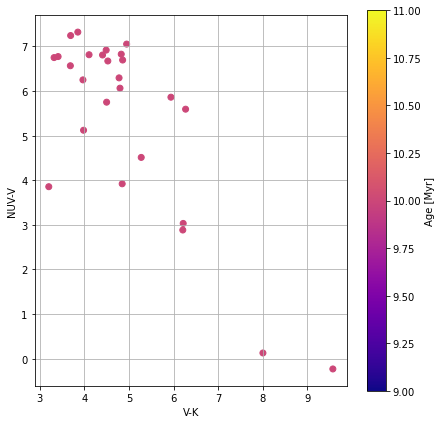

In [65]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.scatter(magV_TWA[matched_i]-magK_TWA[matched_i],nuv_TWA[matched_i]-magV_TWA[matched_i],c=age_TWA[matched_i],cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Age [Myr]')
ax.set_aspect('equal')
plt.ylabel('NUV-V')
plt.xlabel('V-K')
plt.grid()
plt.savefig('colorcolor.jpg')
plt.show()

_**Note**: if you wanted to save the image in a different directory from the current one, you could do so by simply providing the path as the filename in plt.savefig, such as: plt.savefig('../Documents/UV_excess_tutorial/colorcolor.jpg')._

## Exercises

In order to see the UV excess, generally characteristic of young stars, let's repeat the steps followed in this tutorial, but for a sample of older stars. As before, a _.txt_ file has been provided along with this tutorial containing a selection of older stars from the Hipparcos sample which includes the name, right ascension and declination (both in degrees) of the targets studied. The name of this file is: _Platais_et_al_1998.txt_.

### 1. Load the _.txt_ file

The first step would be to load the _.txt_ file using _numpy_ as we did before.

In [48]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

names_Hip, ra_Hip, dec_Hip, age_Hip = np.loadtxt('Platais_et_al_1998.txt', unpack = True, dtype="U10,f8,f8,i4")

Display the contents of the arrays to check everything has been loaded correctly:

- The names of the Hipparcos sample:

In [10]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

print('Name of the stars in the Hipparcos sample: ', names_Hip)

Name of the stars in the Hipparcos sample:  ['HIP_5671' 'HIP_21974' 'HIP_22931' 'HIP_23784' 'HIP_27345' 'HIP_28944'
 'HIP_29577' 'HIP_29713' 'HIP_33175' 'HIP_37742' 'HIP_45080' 'HIP_45189'
 'HIP_51688' 'HIP_55350' 'HIP_67014' 'HIP_67330' 'HIP_67740' 'HIP_83071'
 'HIP_98321' 'HIP_110648']


- The Right Ascension:

In [5]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

print('Right Ascension of the stars in the Hipparcos sample: ', ra_Hip)

Right Ascension of the stars in the Hipparcos sample:  [ 18.4583  70.4042  73.8083  76.8417  87.0667  92.4     93.125   93.8583
 104.3083 116.1125 137.375  138.4458 158.5667 170.0667 205.8667 206.9875
 207.9333 254.3875 299.6375 336.2375]


- The declination:

In [6]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

print('Declination of the stars in the Hipparcos sample: ', dec_Hip)

Declination of the stars in the Hipparcos sample:  [ 32.0283  71.2367  -5.1633  22.2783   4.0117 -22.1517  41.2333   3.845
  -5.92   -37.6667 -59.1283 -43.74   -47.27   -71.9383 -59.1225 -66.02
 -63.4533 -60.98    36.63    56.8283]


- The age:

In [46]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

print('Age of the stars in the Hipparcos sample [Myr]: ', age_Hip)

Age of the stars in the Hipparcos sample [Myr]:  [400 400 100 100 100  60 200  60 100 100  60 100 100 100 100 200 200 100
  60 100]


### 2. Look for the target stars in VO and save their NUV magnitudes

Also as before, let's look the target stars up in the GUVCat catalog through the Virtual Observatory. Do not forget to create a _numpy array_ to store the NUV magnitudes and to check whether the catalog has an entry for the desired star!

In [16]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

n = len(names_Hip)
nuv_Hip = np.zeros(n)

for i in range(n):
    pos = SkyCoord(ra=ra_Hip[i], dec=dec_Hip[i], unit='deg',frame='icrs')
    size = Quantity(50, unit="arcsec")
    scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
    scs_results = scs_service.search(pos=pos, radius=size)
    if (len(scs_results['nuv_mag']) > 0):
        nuv_Hip[i] = float(scs_results['nuv_mag'][0])
    else:
        print(names_Hip[i],'not in GALEX')
        
nuv_Hip

HIP_22931 not in GALEX
HIP_27345 not in GALEX
HIP_28944 not in GALEX
HIP_33175 not in GALEX
HIP_45080 not in GALEX
HIP_45189 not in GALEX
HIP_51688 not in GALEX
HIP_55350 not in GALEX
HIP_67014 not in GALEX
HIP_67740 not in GALEX
HIP_83071 not in GALEX
HIP_98321 not in GALEX
HIP_110648 not in GALEX


array([20.82972908, 22.82538033,  0.        , 21.60828972,  0.        ,
        0.        , 22.28133011, 20.98524094,  0.        , 12.20963001,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       20.81772995,  0.        ,  0.        ,  0.        ,  0.        ])

### 3. Look them up in SIMBAD and save their V, K magnitudes

Use the names provided in the _.txt_ file to look the targets up in SIMBAD. Do not forget to check for missing values of the magnitudes to exclude them from the color-color diagram!

In [20]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

Simbad.add_votable_fields('flux(K)','flux(V)')
n = len(names_Hip)
magK_Hip = []
magV_Hip = []
missing_val_i_Hip = []
    
for i in range(n):
    table = Simbad.query_object(names_Hip[i])
    if (float(table['FLUX_V']) != float(table['FLUX_V'])):
        print('Missing V-band magnitude: ',names_Hip[i])
        missing_val_i_Hip.append(i)
        magK_Hip.append(float(table['FLUX_K']))
        magV_Hip.append(0)
        continue
    elif (float(table['FLUX_K']) != float(table['FLUX_K'])):
        print('Missing K-band magnitude: ',names_Hip[i])
        missing_val_i_Hip.append(i)
        magK_Hip.append(0)
        magV_Hip.append(float(table['FLUX_V']))
        continue
    else:
        magK_Hip.append(float(table['FLUX_K']))
        magV_Hip.append(float(table['FLUX_V']))

magK_Hip = np.array(magK_Hip)
magV_Hip = np.array(magV_Hip)

Missing K-band magnitude:  HIP_45189


### 4. Match the queries between GUVCat and SIMBAD

In [21]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

matched_i_Hip = []

for i in range(len(names_Hip)):
    if (nuv_Hip[i] != 0.) & (i not in missing_val_i_Hip):
        matched_i_Hip.append(i)
        
print(matched_i_Hip)

[0, 1, 3, 6, 7, 9, 15]


### 5. Create the color-color diagram with the older and younger stars

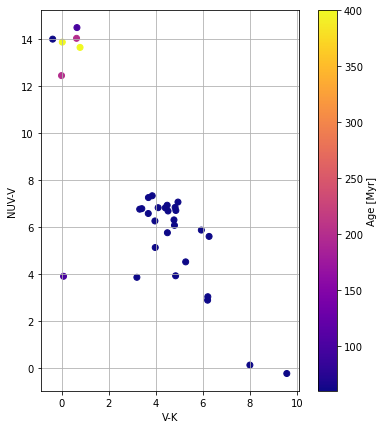

In [64]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.scatter(magV_TWA[matched_i]-magK_TWA[matched_i],nuv_TWA[matched_i]-magV_TWA[matched_i],c=age_TWA[matched_i],cmap='plasma')
plt.scatter(magV_Hip[matched_i_Hip]-magK_Hip[matched_i_Hip],nuv_Hip[matched_i_Hip]-magV_Hip[matched_i_Hip],c=age_Hip[matched_i_Hip],cmap='plasma')
ax.set_aspect('equal')
plt.ylabel('NUV-V')
plt.xlabel('V-K')
cbar = plt.colorbar()
cbar.set_label('Age [Myr]')
plt.grid()
plt.savefig('comparison.jpg')
plt.show()

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

<a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
<a href="https://archive.stsci.edu/hlsp/guvcat">GALEX UV Unique Source Catalogs</a> <br> 
<a href="https://pyvo.readthedocs.io/en/latest/index.html">PyVO documentation</a> <br> 

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Updated on**: 27/07/2022

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>